# Imports

In [94]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import json

from matplotlib.colors import rgb2hex

# Load data

In [33]:
categories = {
                "openflights": "road",
                "us_roads_AK": "road",
                "us_roads_CT": "road",
                "us_roads_NH": "road",
                "us_roads_VT": "road",
                "roadNet-CA": "road",
                "AstroPh": "collaboration",
                "CondMat": "collaboration",
                "HepPh": "collaboration",
                "TerroristRel": "collaboration",
                "marvel_universe": "collaboration",
                "reddit-hyperlink": "social",
                "rt-retweet-crawl": "social",
                "wikipedia_clickstream": "social",
                "digg_reply": "social",
                "email_enron": "social"
            }

In [34]:
results = {}

for key in categories.keys():
    print(key)
    
    with open(f"{key}_False.json") as f:
        json_content = json.load(f) 
        results[key] = json_content

openflights
us_roads_AK
us_roads_CT
us_roads_NH
us_roads_VT
roadNet-CA
AstroPh
CondMat
HepPh
TerroristRel
marvel_universe
reddit-hyperlink
rt-retweet-crawl
wikipedia_clickstream
digg_reply
email_enron


In [35]:
markers_catalog = {
                    "road": "X", 
                    "collaboration": "o", 
                    "social": "^"
                    }

cmap = plt.cm.get_cmap("hsv", 6)

# Network statistics

## Distribution of nodes and edges

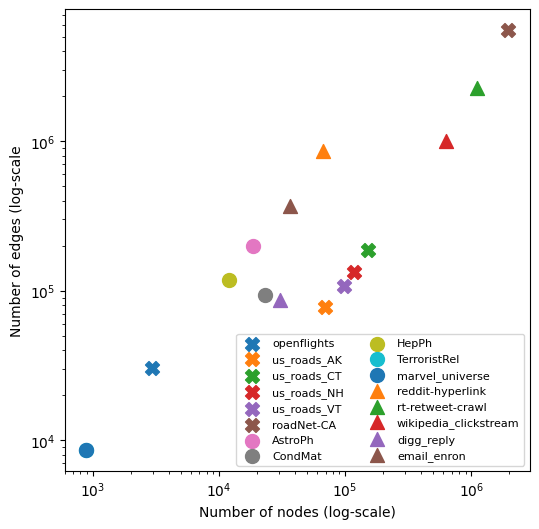

In [45]:
plt.figure(figsize=(6, 6))

scatters = []

for dataset in results.keys():
    s = plt.scatter(results[dataset]["nodes"], results[dataset]["edges"], marker=markers_catalog[categories[dataset]], s=100)
    scatters.append(s)
    
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Number of nodes (log-scale)")
plt.ylabel("Number of edges (log-scale")

plt.legend(scatters,
           [dataset for dataset in results.keys()],
           scatterpoints=1,
           ncol=2,
           loc="lower right",
           fontsize=8
          )
# for index, dataset in enumerate(results.keys()):
#     plt.annotate(dataset, (nnodes[index], nedges[index]))
    
plt.show()

## Relation between diameter, average clustering coefficient and density of networks

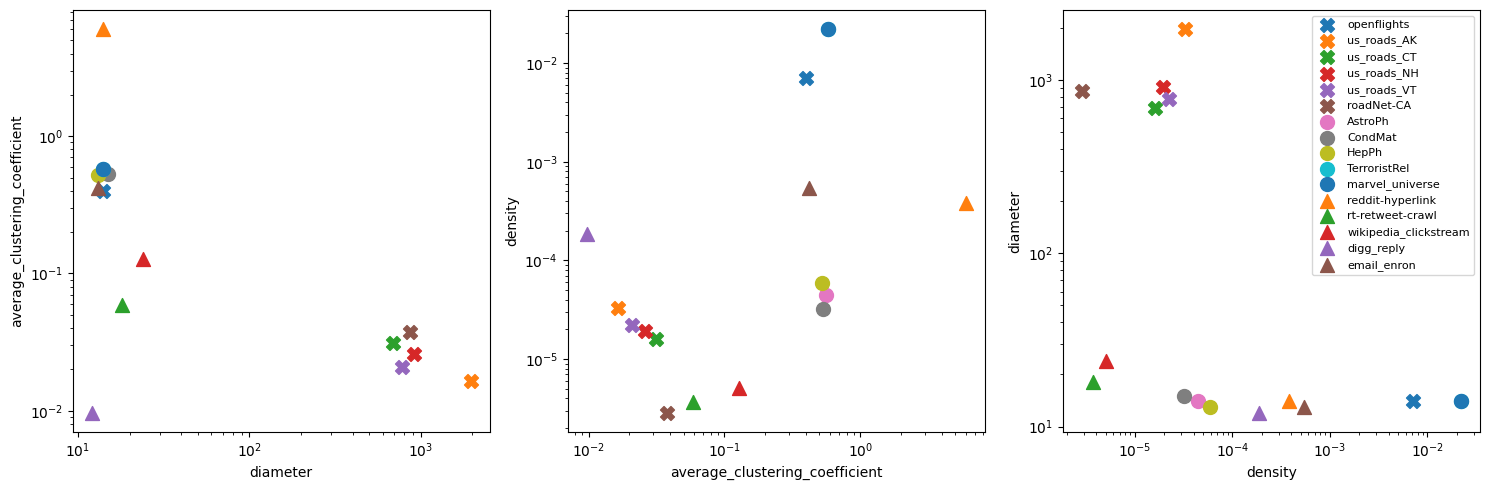

In [79]:
scatters = []
metrics = ["diameter", "average_clustering_coefficient", "density"]

fig, ax = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

for index, metric_1 in enumerate(metrics):
    metric_2 = metrics[(index + 1)%3]
        
    if metric_1 == "diameter":
        metrics_1 = [results[dataset][metric_1][0] for dataset in results.keys()]

    else:
        metrics_1 = [results[dataset][metric_1] for dataset in results.keys()]
        
    if metric_2 == "diameter":
        metrics_2 = [results[dataset][metric_2][0] for dataset in results.keys()]

    else:
        metrics_2 = [results[dataset][metric_2] for dataset in results.keys()]
        
    for j, dataset in enumerate(results.keys()):
        s = ax[index%3].scatter(metrics_1[j], metrics_2[j], marker=markers_catalog[categories[dataset]], s=100)

        if index == 2:
            scatters.append(s)
        
    ax[index%3].set_xscale("log")
    ax[index%3].set_yscale("log")
            
    ax[index%3].set_xlabel(metric_1)
    ax[index%3].set_ylabel(metric_2)
    

plt.legend(scatters,
           [dataset for dataset in results.keys()],
           scatterpoints=1,
           ncol=1,
           loc="upper right",
           fontsize=8
          )

plt.show()

# Time ratios

## Topk closeness BFSCUT to closeness centrality computation time ratio across datasets and k

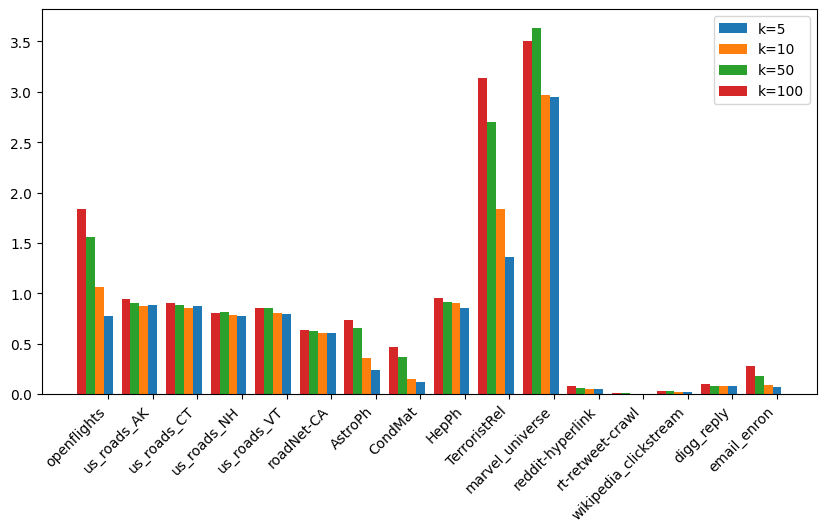

In [90]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

fig, ax = plt.subplots(figsize=(10, 5))

for index_k, k in enumerate(ks):
    ratios = [results[dataset]["time_elapsed"]["topkcloseness_0"][str(k)]/results[dataset]["time_elapsed"]["closeness"] for dataset in results.keys()]
    ax.bar(x - (width * index_k), ratios, width, label=f"k={k}")
    
ax.set_xticks(x, xticklabels, rotation=45, ha="right")
ax.legend()

plt.show()

## Topk closeness LB to closeness centrality computation time ratio across datasets and k

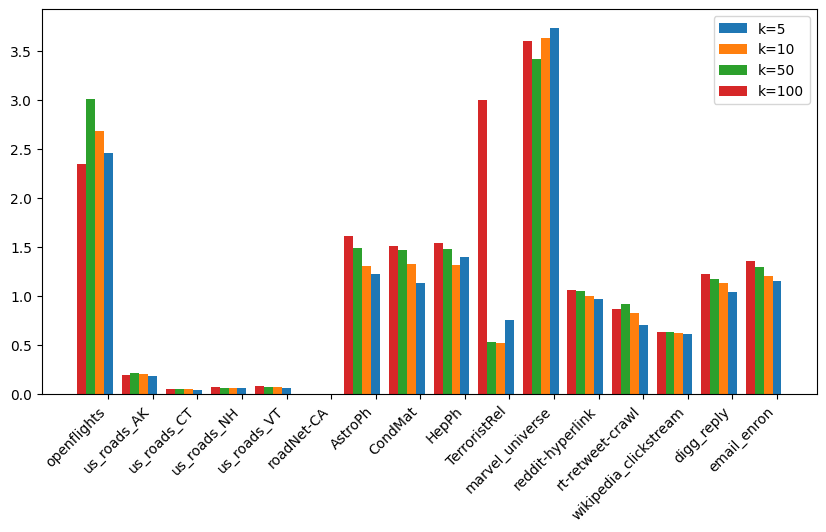

In [91]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

fig, ax = plt.subplots(figsize=(10, 5))

for index_k, k in enumerate(ks):
    ratios = [results[dataset]["time_elapsed"]["topkcloseness_1"][str(k)]/results[dataset]["time_elapsed"]["closeness"] for dataset in results.keys()]
    ax.bar(x - (width * index_k), ratios, width, label=f"k={k}")
    
ax.set_xticks(x, xticklabels, rotation=45, ha="right")
ax.legend()

plt.show()

## Correlation between network metrics and computation time ratio across k

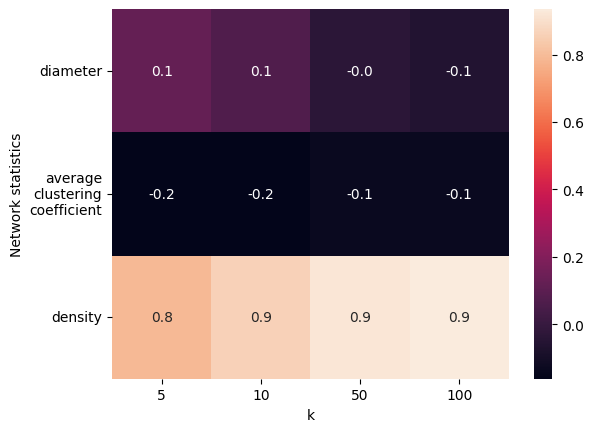

In [141]:
def get_data(variant):
    ks = [5, 10, 50, 100]
    metric_list = ["diameter", "average_clustering_coefficient", "density"]
    data = [[], [], []]

    
    for index_metrics, metric in enumerate(metric_list):
        for index_k, k in enumerate(ks):
            ratios = [results[dataset]["time_elapsed"][variant][str(k)]/results[dataset]["time_elapsed"]["closeness"] for dataset in results.keys()]

            if metric == "diameter":
                metrics = [results[dataset][metric][0] for dataset in results.keys()]

            else:
                metrics = [results[dataset][metric] for dataset in results.keys()]

            data[index_metrics].append(np.corrcoef(metrics, ratios)[0][1])

    data_df = pd.DataFrame(data)
    data_df.columns = ks
    data_df.index = ["diameter", "average\nclustering\ncoefficient", "density"]

    return data_df

sns.heatmap(get_data("topkcloseness_0"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.show()

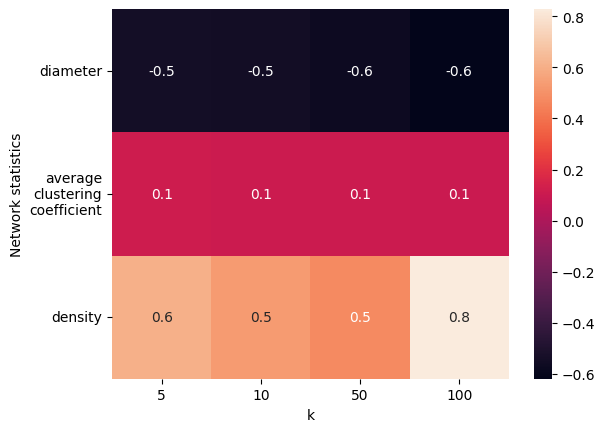

In [142]:
sns.heatmap(get_data("topkcloseness_1"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.show()

# NDCG score

## nDCG scores of closeness centrality wrt degree centrality across datasets and k and network statistics

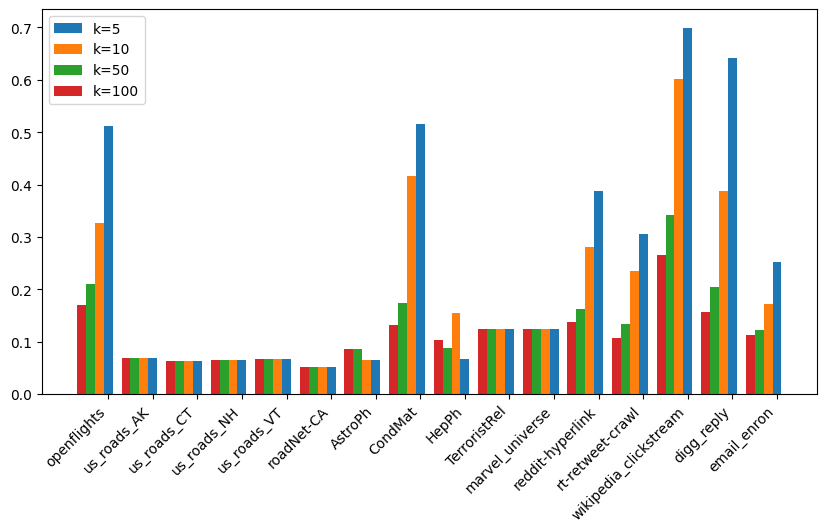

In [146]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

fig, ax = plt.subplots(figsize=(10, 5))

for index_k, k in enumerate(ks):
    ndcg_scores = [results[dataset]["ndcg_degree"][str(k)]["closeness"] for dataset in results.keys()]
    ax.bar(x - (width * index_k), ndcg_scores, width, label=f"k={k}")
    
ax.set_xticks(x, xticklabels, rotation=45, ha="right")
ax.legend()

plt.show()

## Correlation between network metrics and nDCG scores of closeness centrality across k

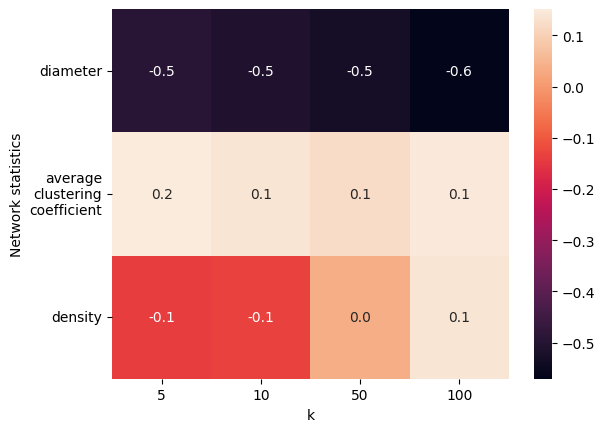

In [147]:
def get_data():
    ks = [5, 10, 50, 100]
    metric_list = ["diameter", "average_clustering_coefficient", "density"]
    data = [[], [], []]

    
    for index_metrics, metric in enumerate(metric_list):
        for index_k, k in enumerate(ks):
            ndcg_scores = [results[dataset]["ndcg_degree"][str(k)]["closeness"] for dataset in results.keys()]

            if metric == "diameter":
                metrics = [results[dataset][metric][0] for dataset in results.keys()]

            else:
                metrics = [results[dataset][metric] for dataset in results.keys()]

            data[index_metrics].append(np.corrcoef(metrics, ndcg_scores)[0][1])

    data_df = pd.DataFrame(data)
    data_df.columns = ks
    data_df.index = ["diameter", "average\nclustering\ncoefficient", "density"]

    return data_df

sns.heatmap(get_data(), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.show()

# Kendalltau

## Kendalltau rank correlation of closeness centrality wrt degree centrality across datasets and k

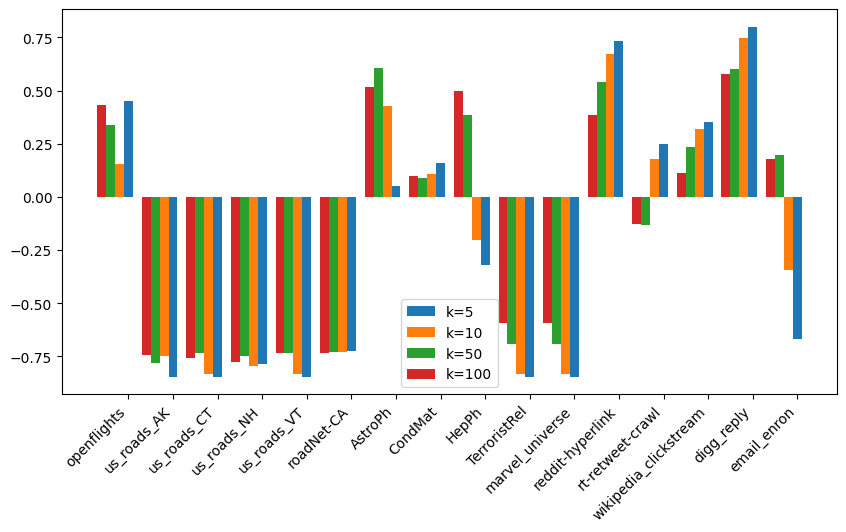

In [151]:
ks = [5, 10, 50, 100]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

fig, ax = plt.subplots(figsize=(10, 5))

for index_k, k in enumerate(ks):
    kendalltau_scores = [results[dataset]["kendalltau"][str(k)]["closeness"] for dataset in results.keys()]
    ax.bar(x - (width * index_k), kendalltau_scores, width, label=f"k={k}")
    
ax.set_xticks(x, xticklabels, rotation=45, ha="right")
ax.legend()

plt.show()

## Kendalltau rank correlation closeness centrality vs topk closeness BFSCUT and LB across datasets and k=100

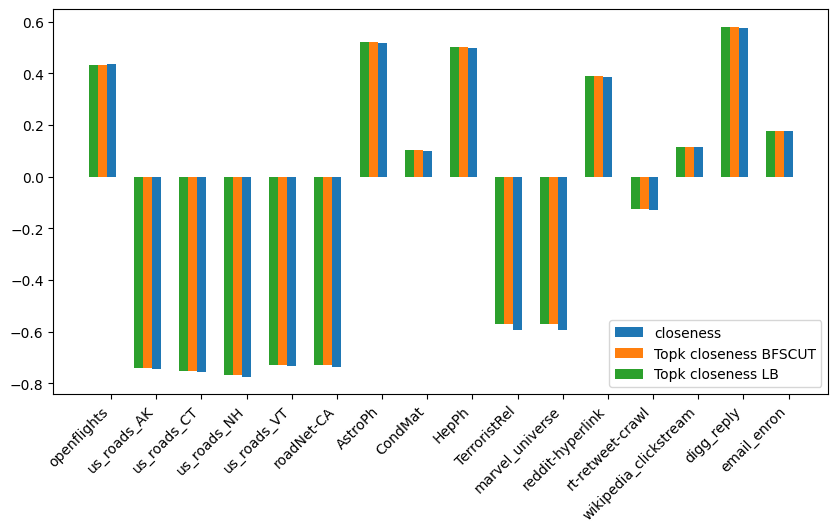

In [155]:
centrality_measures = ["closeness", "topkcloseness_0", "topkcloseness_1"]
labels = ["closeness", "Topk closeness BFSCUT", "Topk closeness LB"]
xticklabels = [dataset for dataset in results.keys()]
width = 0.2
x = np.arange(len(xticklabels))

fig, ax = plt.subplots(figsize=(10, 5))

for index_centrality_measure, (centrality_measure, label) in enumerate(zip(centrality_measures, labels)):
    kendalltau_scores = [results[dataset]["kendalltau"][str(k)][centrality_measure] for dataset in results.keys()]
    ax.bar(x - (width * index_centrality_measure), kendalltau_scores, width, label=label)
    
ax.set_xticks(x, xticklabels, rotation=45, ha="right")
ax.legend()

plt.show()

## Correlation between network metrics and Kendalltau ranking correlation scores of closeness centrality across k

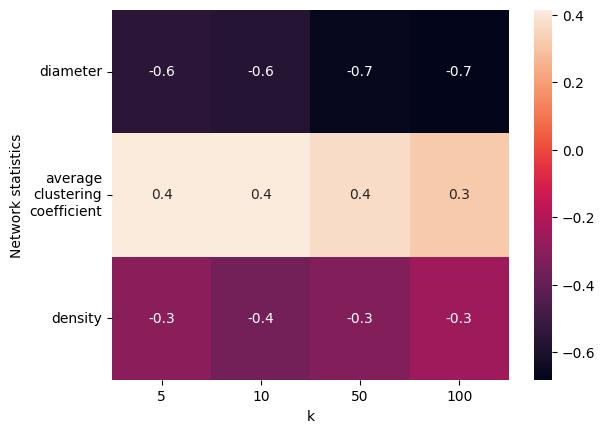

In [157]:
def get_data(variant):
    ks = [5, 10, 50, 100]
    metric_list = ["diameter", "average_clustering_coefficient", "density"]
    data = [[], [], []]

    
    for index_metrics, metric in enumerate(metric_list):
        for index_k, k in enumerate(ks):
            kendalltau_scores = [results[dataset]["kendalltau"][str(k)][variant] for dataset in results.keys()]

            if metric == "diameter":
                metrics = [results[dataset][metric][0] for dataset in results.keys()]

            else:
                metrics = [results[dataset][metric] for dataset in results.keys()]

            data[index_metrics].append(np.corrcoef(metrics, kendalltau_scores)[0][1])

    data_df = pd.DataFrame(data)
    data_df.columns = ks
    data_df.index = ["diameter", "average\nclustering\ncoefficient", "density"]

    return data_df

sns.heatmap(get_data("closeness"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.show()

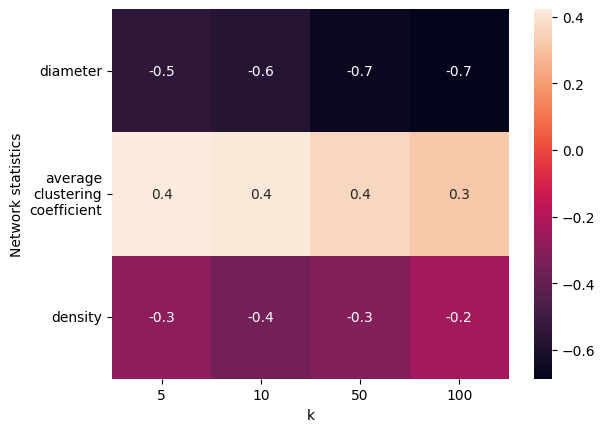

In [159]:
sns.heatmap(get_data("topkcloseness_0"), annot=True, fmt=".1f")
plt.yticks(rotation=0)
plt.xlabel("k")
plt.ylabel("Network statistics")

plt.show()

## NDCG scores for k=5, 100 across centrality measures vs diameter

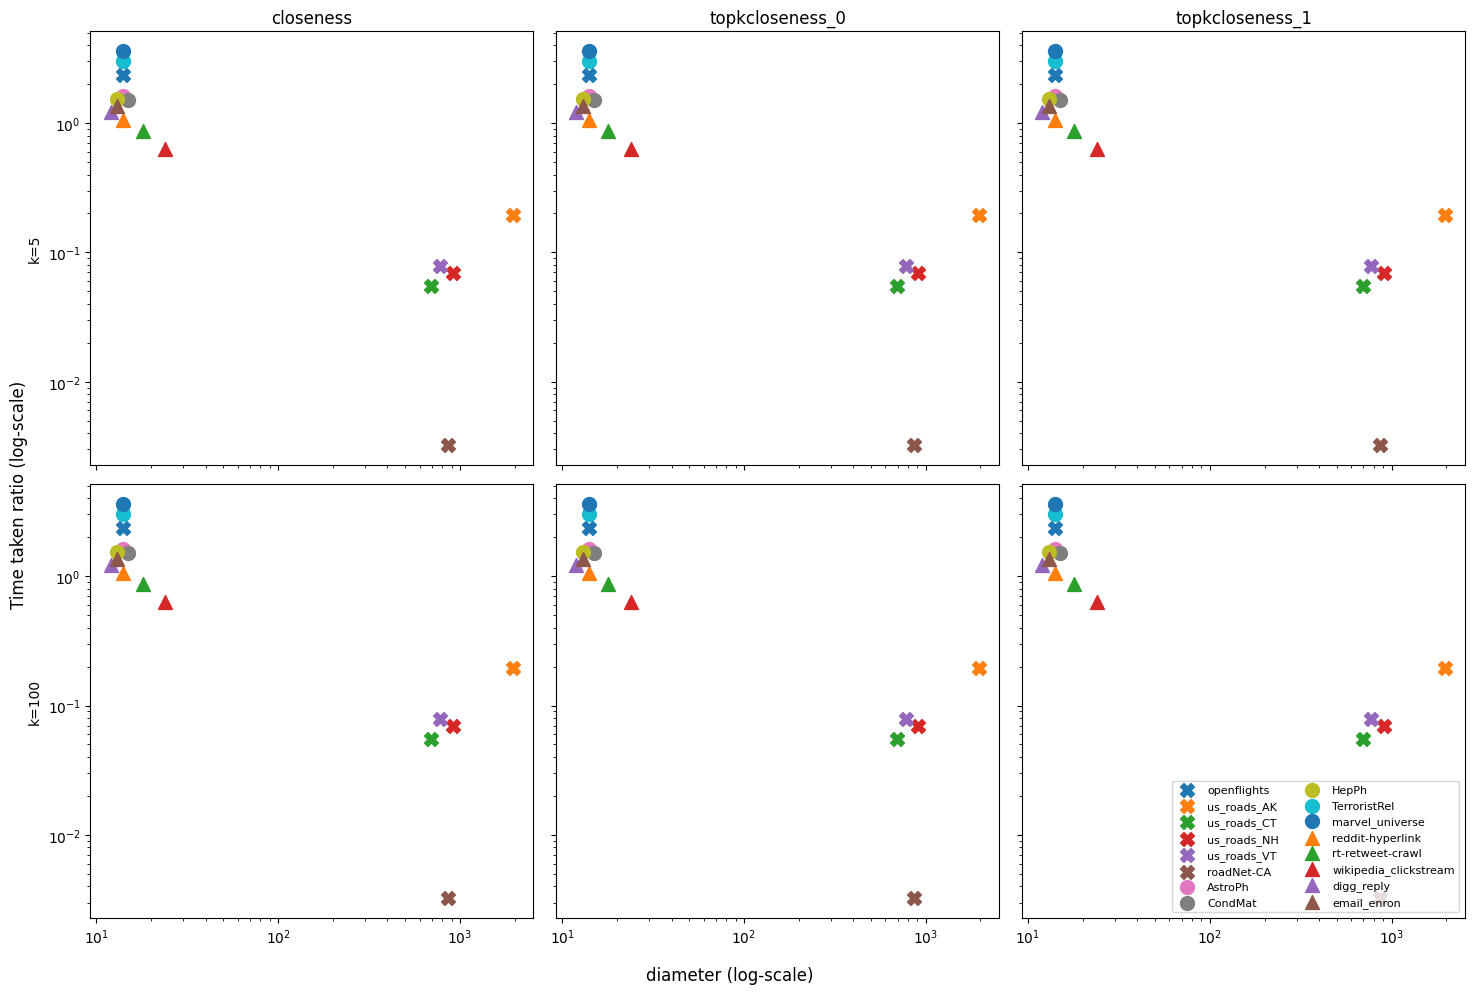

In [74]:
metric = "diameter"
ks = [5, 100]
scatters = []

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, tight_layout=True)

for index_row, k in enumerate(ks):
    for index_col, centrality_measure in enumerate(["closeness", "topkcloseness_0", "topkcloseness_1"]):
    
        ndcg_scores = [results[dataset]["ndcg_degree"][str(k)][centrality_measure] for dataset in results.keys()]
        metrics = [results[dataset][metric][0] for dataset in results.keys()]

        for j, dataset in enumerate(results.keys()):
            s = ax[index_row, index_col].scatter(metrics[j], ratios[j], marker=markers_catalog[categories[dataset]], s=100)

            ax[index_row, index_col].set_xscale("log")
            ax[index_row, index_col].set_yscale("log")

            if index_row == 0:
                ax[index_row, index_col].set_title(centrality_measure)
                
            if index_col == 0:
                ax[index_row, index_col].set_ylabel(f"k={k}")
                
            if (index_row == 1) & (index_col == 2):
                scatters.append(s)
    
fig.supxlabel(f"{metric} (log-scale)")
fig.supylabel("Time taken ratio (log-scale)")

plt.legend(scatters,
           [dataset for dataset in results.keys()],
           scatterpoints=1,
           ncol=2,
           loc="lower right",
           fontsize=8
          )

plt.show()

## NDCG scores for k=5, 100 across centrality measures vs average clustering coefficient

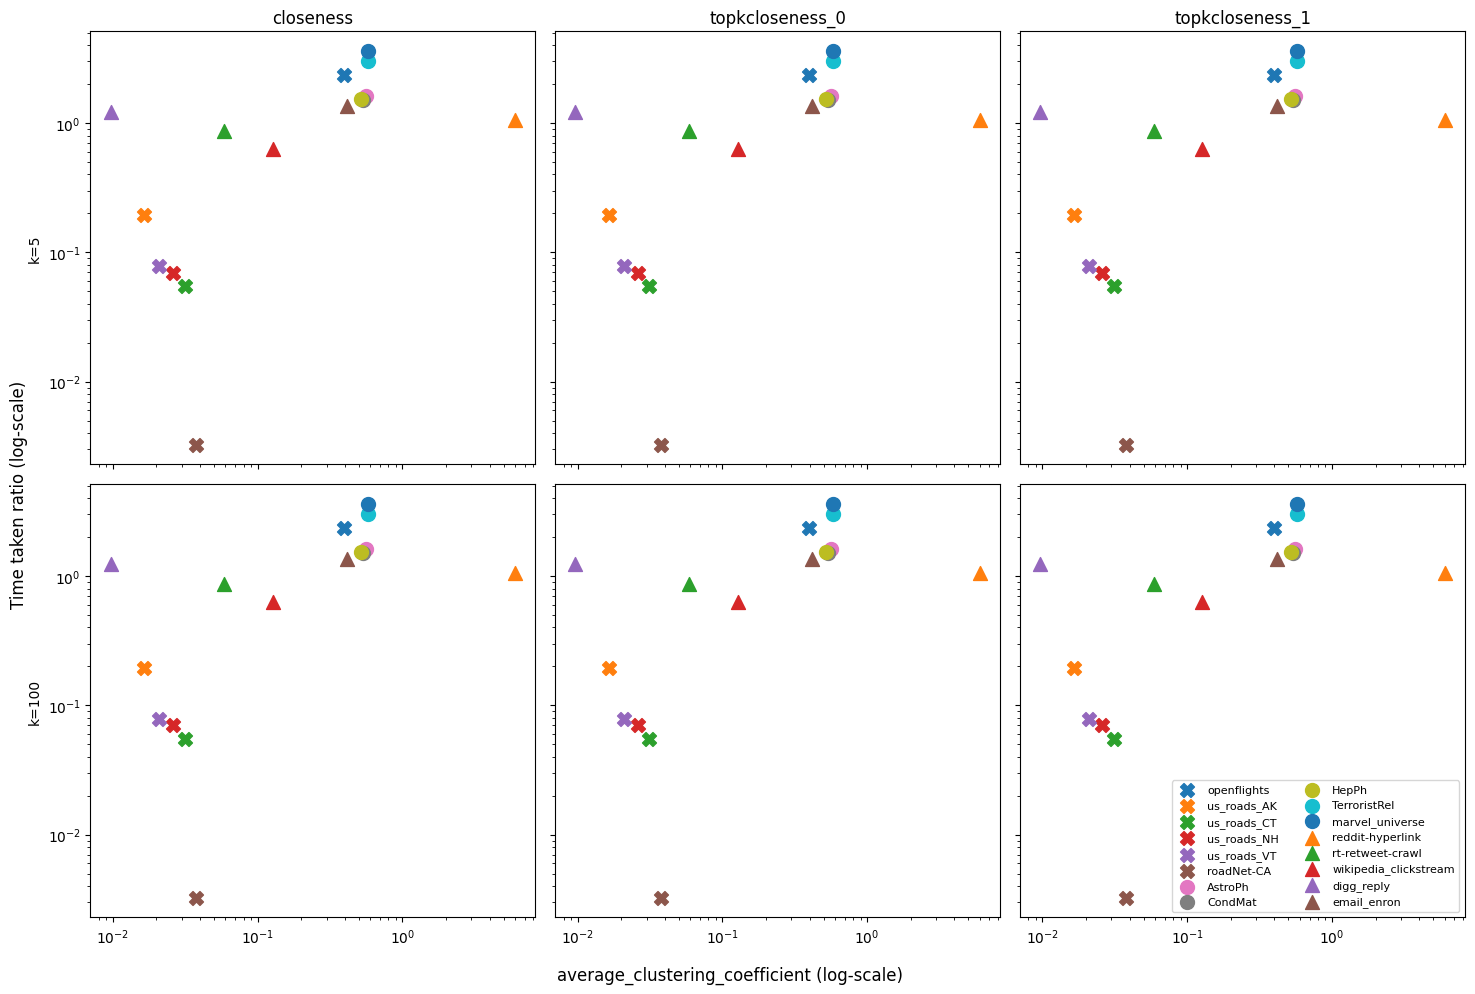

In [75]:
metric = "average_clustering_coefficient"
ks = [5, 100]
scatters = []

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, tight_layout=True)

for index_row, k in enumerate(ks):
    for index_col, centrality_measure in enumerate(["closeness", "topkcloseness_0", "topkcloseness_1"]):
    
        ndcg_scores = [results[dataset]["ndcg_degree"][str(k)][centrality_measure] for dataset in results.keys()]
        metrics = [results[dataset][metric] for dataset in results.keys()]

        for j, dataset in enumerate(results.keys()):
            s = ax[index_row, index_col].scatter(metrics[j], ratios[j], marker=markers_catalog[categories[dataset]], s=100)

            ax[index_row, index_col].set_xscale("log")
            ax[index_row, index_col].set_yscale("log")

            if index_row == 0:
                ax[index_row, index_col].set_title(centrality_measure)
                
            if index_col == 0:
                ax[index_row, index_col].set_ylabel(f"k={k}")
                
            if (index_row == 1) & (index_col == 2):
                scatters.append(s)
    
fig.supxlabel(f"{metric} (log-scale)")
fig.supylabel("Time taken ratio (log-scale)")

plt.legend(scatters,
           [dataset for dataset in results.keys()],
           scatterpoints=1,
           ncol=2,
           loc="lower right",
           fontsize=8
          )

plt.show()

## NDCG scores for k=5, 100 across centrality measures vs density

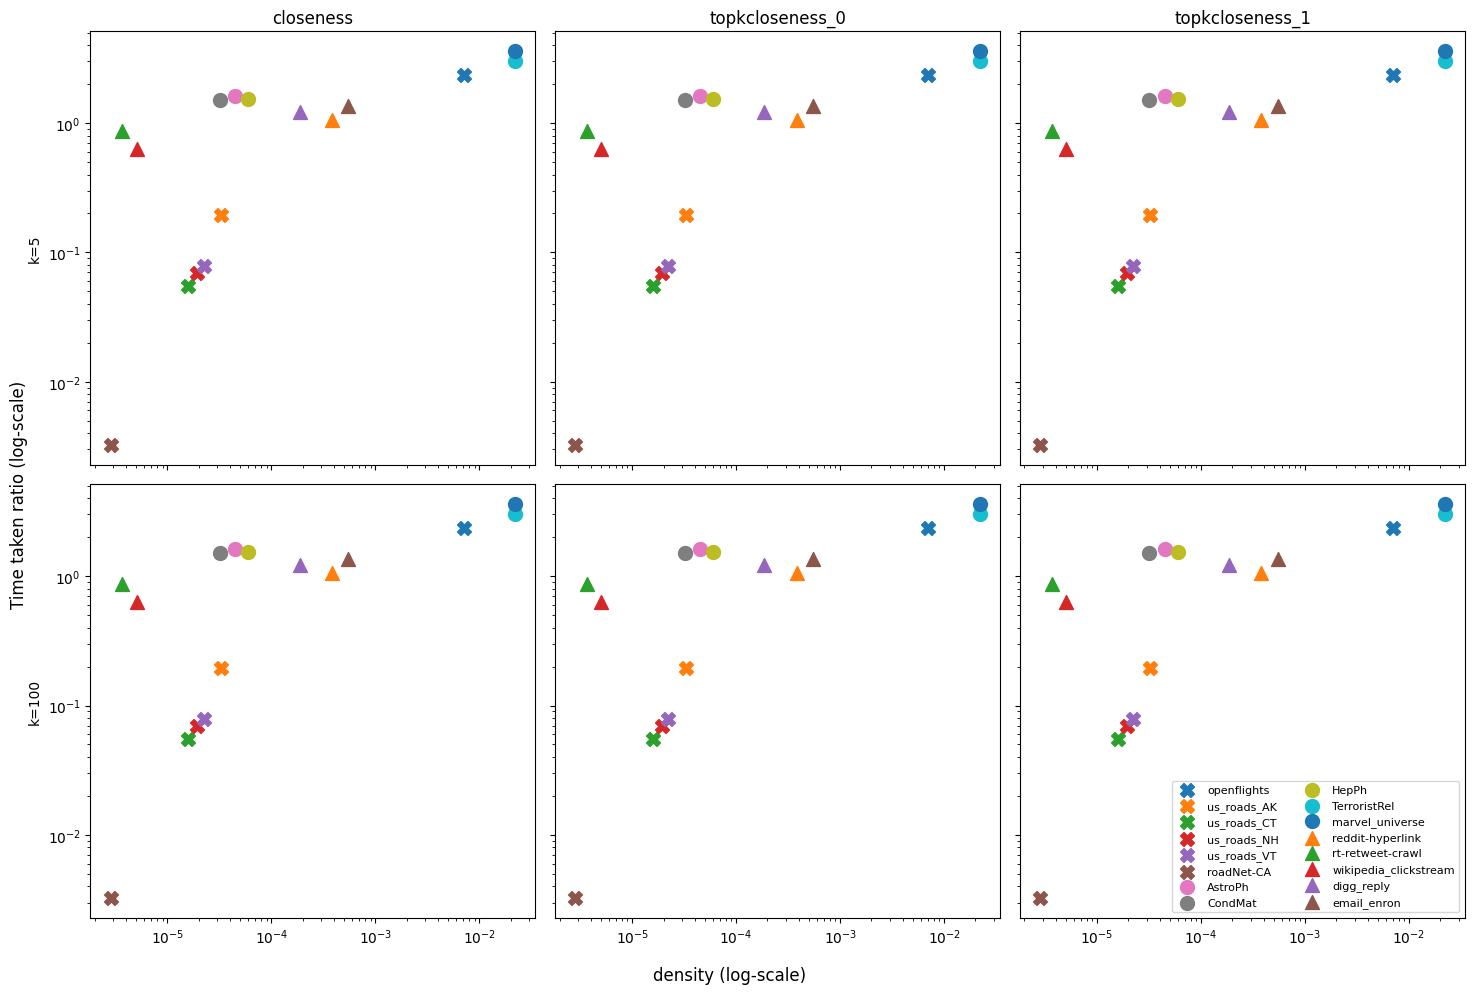

In [76]:
metric = "density"
ks = [5, 100]
scatters = []

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True, tight_layout=True)

for index_row, k in enumerate(ks):
    for index_col, centrality_measure in enumerate(["closeness", "topkcloseness_0", "topkcloseness_1"]):
    
        ndcg_scores = [results[dataset]["ndcg_degree"][str(k)][centrality_measure] for dataset in results.keys()]
        metrics = [results[dataset][metric] for dataset in results.keys()]

        for j, dataset in enumerate(results.keys()):
            s = ax[index_row, index_col].scatter(metrics[j], ratios[j], marker=markers_catalog[categories[dataset]], s=100)

            ax[index_row, index_col].set_xscale("log")
            ax[index_row, index_col].set_yscale("log")

            if index_row == 0:
                ax[index_row, index_col].set_title(centrality_measure)
                
            if index_col == 0:
                ax[index_row, index_col].set_ylabel(f"k={k}")
                
            if (index_row == 1) & (index_col == 2):
                scatters.append(s)
    
fig.supxlabel(f"{metric} (log-scale)")
fig.supylabel("Time taken ratio (log-scale)")

plt.legend(scatters,
           [dataset for dataset in results.keys()],
           scatterpoints=1,
           ncol=2,
           loc="lower right",
           fontsize=8
          )

plt.show()